In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
import numpy as np

In [24]:
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

In [25]:
df = pd.read_parquet("https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset/final_gpu_time_windows.parquet")
df.groupby(["app_name", "label"]).size()
df.head()

,pid,comm,uid,gid,ppid,user_pid,user_ppid,cgroup_id,cgroup_name,user,...,memcpy_rate,alloc_rate,wall_time_dt,wall_time_ms,container_id,container_image,container_labels_json,app_name,label,experiment_time
0,64666,hashcat,0,0,0,0,0,0,,,...,4.0,0.0,2025-11-11 22:31:33.200000+00:00,1762900293200,,,{},passwd_hashcat,1,20251111T222850Z
1,64666,hashcat,0,0,0,0,0,0,,,...,0.0,0.0,2025-11-11 22:31:36.994000+00:00,1762900296994,,,{},passwd_hashcat,1,20251111T222850Z
2,64417,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:41.469000+00:00,1762900121469,,,{},passwd_hashcat,1,20251111T222850Z
3,64443,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:45.610000+00:00,1762900125610,,,{},passwd_hashcat,1,20251111T222850Z
4,64469,hashcat,0,0,0,0,0,0,,,...,13.0,14.5,2025-11-11 22:28:48.582000+00:00,1762900128582,,,{},passwd_hashcat,1,20251111T222850Z


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   pid                     2848 non-null   uint32             
 1   comm                    2848 non-null   object             
 2   uid                     2848 non-null   uint32             
 3   gid                     2848 non-null   uint32             
 4   ppid                    2848 non-null   uint32             
 5   user_pid                2848 non-null   uint32             
 6   user_ppid               2848 non-null   uint32             
 7   cgroup_id               2848 non-null   uint64             
 8   cgroup_name             2848 non-null   object             
 9   user                    2848 non-null   object             
 10  window_start_ns         2848 non-null   int64              
 11  window_end_ns           2848 non-null   int

In [27]:
df.isna().sum()

pid                       0
comm                      0
uid                       0
gid                       0
ppid                      0
user_pid                  0
user_ppid                 0
cgroup_id                 0
cgroup_name               0
user                      0
window_start_ns           0
window_end_ns             0
kernel_launch_count       0
mem_alloc_count           0
memcpy_count              0
stream_sync_count         0
avg_threads_per_kernel    0
max_threads_per_kernel    0
avg_blocks_per_kernel     0
total_threads_launched    0
total_mem_alloc_bytes     0
avg_mem_alloc_bytes       0
total_memcpy_bytes        0
avg_memcpy_bytes          0
htod_bytes                0
dtoh_bytes                0
htod_ratio                0
avg_sync_time_ns          0
max_sync_time_ns          0
sync_fraction             0
launch_rate               0
memcpy_rate               0
alloc_rate                0
wall_time_dt              0
wall_time_ms              0
container_id        

In [28]:
counts = df["label"].value_counts()
print(counts)

# Or more descriptive:
print("Benign (0):", counts.get(0, 0))
print("Malign (1):", counts.get(1, 0))
print("Total:", len(df))

label
0    1713
1    1135
Name: count, dtype: int64
Benign (0): 1713
Malign (1): 1135
Total: 2848


In [29]:
counts = df["app_name"].value_counts()
print(counts)

app_name
llm_gpt_neo       754
miner_xmrig       679
passwd_hashcat    456
ml_svm            241
llm_gpt           190
llm_bert          132
dl_lstm_train     131
dl_cnn_train      109
llm_roberta        85
ml_logreg          46
ml_forest          25
Name: count, dtype: int64


In [30]:
df["experiment_id"] = df["app_name"].astype(str) + "_" + df["experiment_time"].astype(str)

In [31]:
drop_cols = [
    "pid", "uid", "gid", "ppid", "user_pid", "user_ppid",
    "cgroup_id", "cgroup_name", "user",
    "container_id", "container_image", "container_labels_json",
    "experiment_time", "wall_time_dt", "wall_time_ms", "window_start_ns", "window_end_ns"
]
df = df.drop(columns=drop_cols, errors="ignore")


In [32]:
X = df.drop(columns=["label", "app_name", "comm", "experiment_id", "label"])
y = df["label"]
groups = df["experiment_id"]

In [33]:
scaler = StandardScaler()
num_cols = X.select_dtypes(include=["float64", "int64", "uint64", "uint32"]).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

In [34]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

In [35]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 2112
Test size : 736


In [36]:
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="auc",
    n_jobs=-1,
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

/home/aleyi/miniconda3/envs/infrasight-ml/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [18:07:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [37]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

acc = (y_pred == y_test).mean()
auc = roc_auc_score(y_test, y_prob)

print("\n=== XGBoost RESULTS ===")
print(f"Accuracy : {acc:.4f}")
print(f"AUC      : {auc:.4f}")
print(classification_report(y_test, y_pred))


=== XGBoost RESULTS ===
Accuracy : 0.9973
AUC      : 1.0000
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       323
           1       1.00      1.00      1.00       413

    accuracy                           1.00       736
   macro avg       1.00      1.00      1.00       736
weighted avg       1.00      1.00      1.00       736



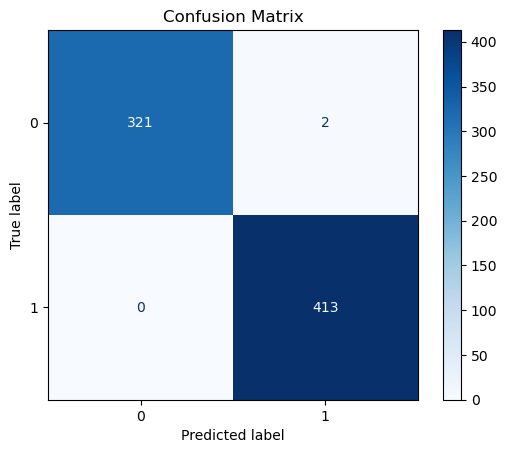

In [38]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

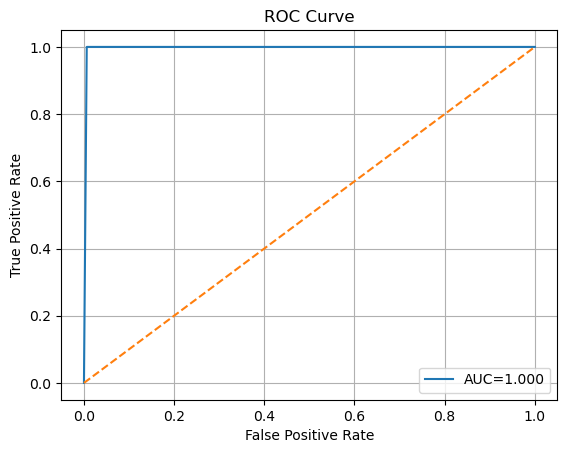

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_11614/3656878119.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_series.values[:20], y=gain_series.index[:20], palette="viridis")


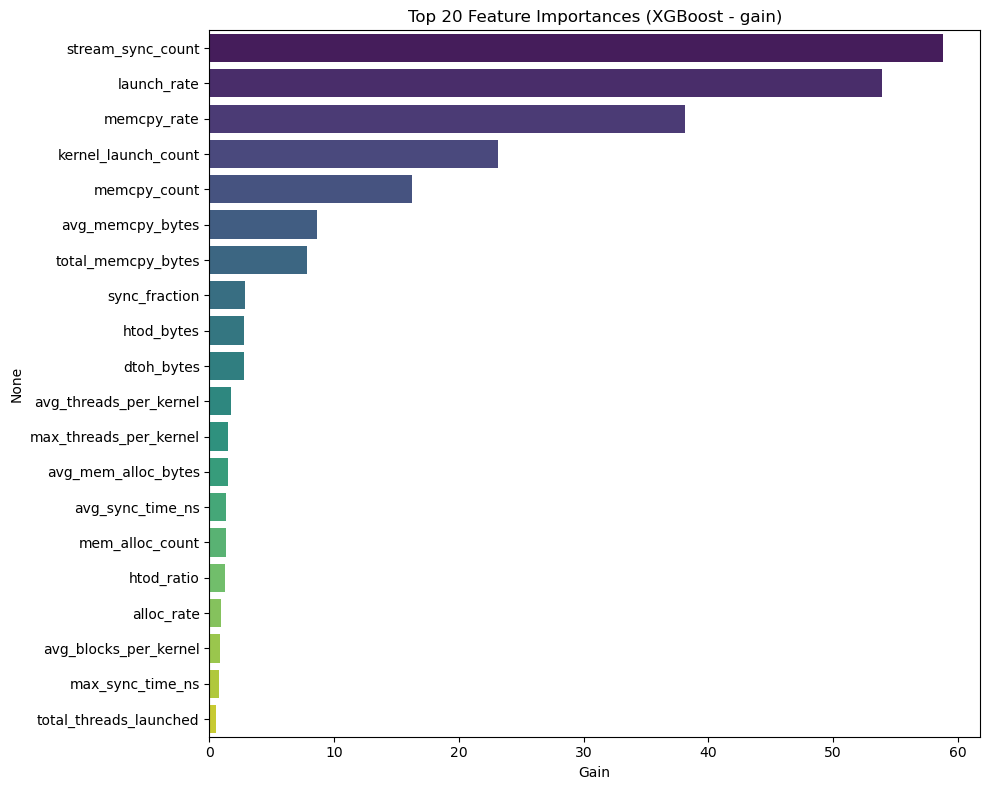


Top 20 XGBoost importances (gain):
stream_sync_count         58.841320
launch_rate               53.929165
memcpy_rate               38.159279
kernel_launch_count       23.151497
memcpy_count              16.216780
avg_memcpy_bytes           8.607787
total_memcpy_bytes         7.844440
sync_fraction              2.847274
htod_bytes                 2.782478
dtoh_bytes                 2.778556
avg_threads_per_kernel     1.726164
max_threads_per_kernel     1.524173
avg_mem_alloc_bytes        1.473673
avg_sync_time_ns           1.341546
mem_alloc_count            1.330115
htod_ratio                 1.260491
alloc_rate                 0.890841
avg_blocks_per_kernel      0.832524
max_sync_time_ns           0.734220
total_threads_launched     0.497983
dtype: float64


In [40]:
booster = model.get_booster()
# get_score returns dict feature -> score (default type 'weight'); specify importance_type
gain = booster.get_score(importance_type="gain")
# convert to series and align with X columns (xgboost names features as 'f0','f1',..)
# Build mapping f{idx} -> column name
feature_map = {f"f{idx}": col for idx, col in enumerate(X.columns)}
gain_series = pd.Series({feature_map.get(k,k): v for k,v in gain.items()})
gain_series = gain_series.sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=gain_series.values[:20], y=gain_series.index[:20], palette="viridis")
plt.xlabel("Gain")
plt.title("Top 20 Feature Importances (XGBoost - gain)")
plt.tight_layout()
plt.show()

print("\nTop 20 XGBoost importances (gain):")
print(gain_series.head(20))


[SHAP] computing TreeExplainer (may take a moment)...


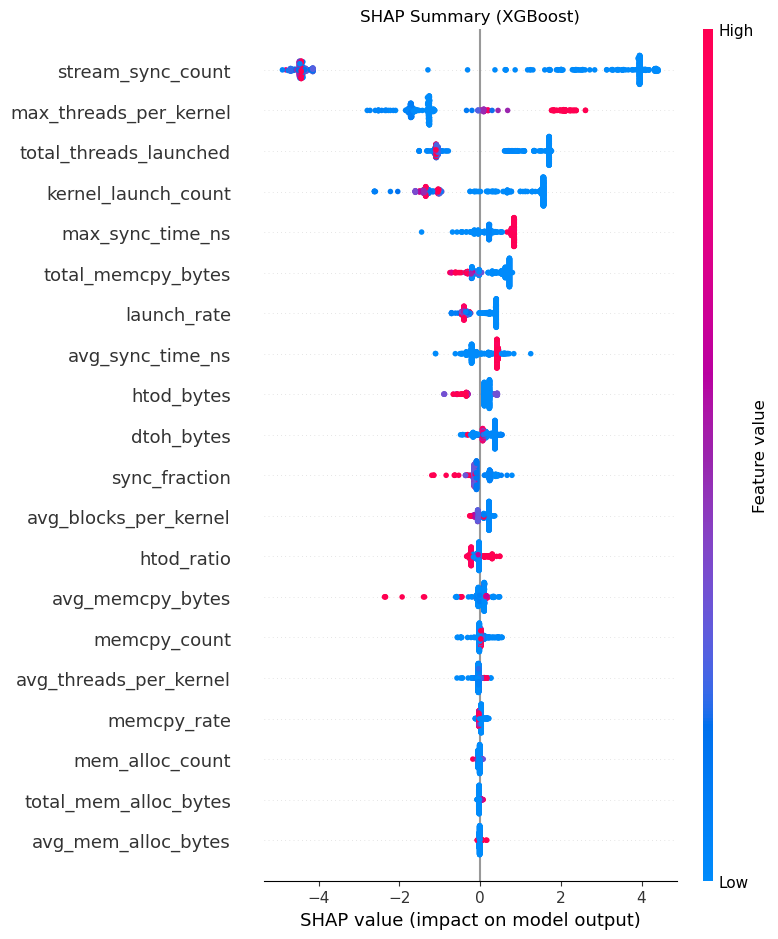

In [41]:
if SHAP_AVAILABLE:
    print("\n[SHAP] computing TreeExplainer (may take a moment)...")
    explainer = shap.TreeExplainer(model)
    # Use a small sample for speed
    sample = X_test.sample(min(500, len(X_test)), random_state=42)
    shap_values = explainer.shap_values(sample)
    plt.title("SHAP Summary (XGBoost)")
    shap.summary_plot(shap_values, sample, show=True)
else:
    print("\n[SHAP] not available. Install shap (`pip install shap`) to view SHAP summary plots.")

In [42]:
def evaluate_dataset_xgb(df_test, model, train_features, label_for_dataset, num_cols=num_cols):
    # Drop metadata columns
    df_test_clean = df_test.drop(columns=drop_cols, errors="ignore")
    
    # Align feature columns
    df_test_clean = df_test_clean[train_features]

    # Apply same scaler used during training
    df_test_clean[num_cols] = scaler.transform(df_test_clean[num_cols])

    # Predictions
    y_pred = model.predict(df_test_clean)
    y_prob = model.predict_proba(df_test_clean)[:, 1]

    print(y_pred)

    # True labels
    y_true = np.full(len(y_pred), label_for_dataset)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Handle single-class dataset edge case
    if cm.size == 1:  
        if label_for_dataset == 0:  # only benign
            tn, fp = cm[0][0], 0
            fn, tp = 0, 0
        else:                       # only malign
            tp, fn = cm[0][0], 0
            tn, fp = 0, 0
    else:
        tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)

    print("\n==============================")
    print("      XGBOOST EVALUATION")
    print("==============================")
    print(f"Dataset label            : {label_for_dataset}  "
          f"({'benign' if label_for_dataset==0 else 'malign'})")
    print(f"Samples                  : {len(y_pred)}")
    print(f"Accuracy                 : {accuracy:.4f}")
    print(f"Predicted positives      : {y_pred.sum()}")
    print(f"Predicted negatives      : {(y_pred==0).sum()}")

    print("\nConfusion Matrix:")
    print(f"TN={tn}   FP={fp}")
    print(f"FN={fn}   TP={tp}")

    return {
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "accuracy": accuracy,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }

In [43]:
df_malign = pd.read_parquet(
    "https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset/miner_lolminer/20251114T231240Z/audit_gpu_time_window_events.parquet"
)

results_malign_xgb = evaluate_dataset_xgb(
    df_test=df_malign,
    model=model,
    train_features=X_train.columns,
    label_for_dataset=1
)


[1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]

      XGBOOST EVALUATION
Dataset label            : 1  (malign)
Samples                  : 45
Accuracy                 : 0.9333
Predicted positives      : 42
Predicted negatives      : 3

Confusion Matrix:
TN=0   FP=0
FN=3   TP=42


In [44]:
df_benign = pd.read_parquet(
    "https://github.com/ALEYI17/gpu_test_infrasight/raw/refs/heads/main/dataset/llm_bloom/20251118T222203Z/audit_gpu_time_window_events.parquet"
)

results_benign_xgb = evaluate_dataset_xgb(
    df_test=df_benign,
    model=model,
    train_features=X_train.columns,
    label_for_dataset=0
)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]

      XGBOOST EVALUATION
Dataset label            : 0  (benign)
Samples                  : 79
Accuracy                 : 1.0000
Predicted positives      : 0
Predicted negatives      : 79

Confusion Matrix:
TN=79   FP=0
FN=0   TP=0
